# Forest Cover Type  Prediction
#### Submitted By: Haihui Cao, Felipe Vergara, Angshuman Paul
**Kaggle Link:** https://www.kaggle.com/c/forest-cover-type-prediction/ 

*Dataset Provided By: Jock A. Blackard and Colorado State University*

*Dataset Hosted By: Bache, K. & Lichman, M. (2013). <a href="http://archive.ics.uci.edu/ml">UCI Machine Learning Repository.</a> Irvine, CA: University of California, School of Information and Computer Science*

## Overview
This project is based on the Kaggle Competition for 'Forest Cover Type Prediction'. In this competition we are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The seven types are:
- 1 .Spruce/Fir
- 2 .Lodgepole Pine
- 3 .Ponderosa Pine
- 4 .Cottonwood/Willow
- 5 .Aspen
- 6 .Douglas-fir
- 7 .Krummholz

The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

## Data Description
The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

**Data Fields:**
- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The details of the wilderness areas and soil types are available in the <a href="https://www.kaggle.com/c/forest-cover-type-prediction/data">Kaggle Data Page</a> for this competition.

## Setup

In [1]:
#General Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from pandas.plotting import scatter_matrix

# Import sklearn_pandas to use pandas with scipy packages
# from sklearn_pandas import DataFrameMapper

%matplotlib inline

np.warnings.filterwarnings('ignore')

SEED = 0
np.random.seed(SEED)

In [2]:
#SKLearn Imports - Once analysis is complete, should remove the ones that are not used

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GDC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix

/Users/apaul2/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#Set working directories - Enable relevant directory when working
#Working Directory for AP 
os.chdir('/Users/apaul2/Documents/_Others/_Temp/mids/W207-AppliedMachineLearning/CourseMaterials/FinalProject/')

#Working Directory for HC
# os.chdir('/Users/HaihuiCao/Desktop/W207_MachineLearning/project/final')

#Working Directory for FV
# os.chdir('//home/felipe/berkeley/w207/projects/group_project/')

In [4]:
#Load Data
train_data_orig=pd.read_csv("train.csv")
test_data_orig=pd.read_csv("test.csv")

In [5]:
#Inspect Data Structure
train_data_orig.shape, test_data_orig.shape

((15120, 56), (565892, 55))

In [6]:
set(train_data_orig.columns) - set(test_data_orig.columns)

{'Cover_Type'}

The train dataset has 15120 observations with 55 features each while the test dataset has 565892 observations with the same number of features.

In [7]:
# Rename longer column names to get cleaner labels in plots
train_data_orig.columns = train_data_orig.columns.str.replace('Horizontal_Distance_To_','HD.') 
train_data_orig.columns = train_data_orig.columns.str.replace('Vertical_Distance_To_','VD.')
train_data_orig.columns = train_data_orig.columns.str.replace('Hillshade_','HS.')
train_data_orig.columns = train_data_orig.columns.str.replace('Wilderness_Area','WA')
train_data_orig.columns = train_data_orig.columns.str.replace('Soil_Type','ST')

The train data has an additional column for the dependent column 'Cover Type'. We separate this out as the label dataset. We will also drop this column from the train_data. Column 'Id' is also dropped as it is just a row identifier and not useful for classification.

In [8]:
train_label=train_data_orig['Cover_Type']
train_data = train_data_orig.copy()
train_data.drop(['Cover_Type','Id'],axis=1, inplace=True)

In [9]:
#List of cover types
cover_types=['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen'
             ,'Douglas-fir','Krummholz']

In [10]:
# Shuffle training data
shuffle=np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_label = train_data.iloc[shuffle, :], train_label[shuffle]

In [11]:
# Check number of labels for each Cover Type
train_label.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

The training dataset has equal number of rows for each Cover Type.

We split the train data into train and dev so that we can evaluate the accuracy of the models without using the test data. We use a 75-25 split for the train and dev datasets.

In [12]:
# Split training data and labels using 75-25 split
train_data,dev_data,train_label,dev_label = train_test_split(train_data, train_label, test_size=0.25, 
                                                             random_state=SEED)
print("Train Data shape: {}, Train Labels shape: {}".format(train_data.shape, train_label.shape))
print("Dev Data shape: {}, Dev Labels shape: {}".format(dev_data.shape, dev_label.shape))

Train Data shape: (11340, 54), Train Labels shape: (11340,)
Dev Data shape: (3780, 54), Dev Labels shape: (3780,)


In [13]:
# Check number of labels for each Cover Type after data splie
train_label.value_counts()

6    1642
3    1635
1    1629
4    1624
2    1620
7    1601
5    1589
Name: Cover_Type, dtype: int64

Although after the split,  the distribution of data for the different cover types is different, we have good representation for each cover types in the training data. This distribution is better for our purpose as we will rarely get equal samples of each target type when dealing with data in the real world.

## Exploratory Data Analysis

In [14]:
pd.set_option('display.max_columns', None)
train_data.head()

,Elevation,Aspect,Slope,HD.Hydrology,VD.Hydrology,HD.Roadways,HS.9am,HS.Noon,HS.3pm,HD.Fire_Points,WA1,WA2,WA3,WA4,ST1,ST2,ST3,ST4,ST5,ST6,ST7,ST8,ST9,ST10,ST11,ST12,ST13,ST14,ST15,ST16,ST17,ST18,ST19,ST20,ST21,ST22,ST23,ST24,ST25,ST26,ST27,ST28,ST29,ST30,ST31,ST32,ST33,ST34,ST35,ST36,ST37,ST38,ST39,ST40
9175,3322,135,12,180,0,1931,239,235,124,3255,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3982,2159,335,7,0,0,1110,205,231,165,779,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8373,3426,177,14,540,226,2418,226,247,150,782,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
14332,3377,169,25,300,148,3813,229,241,127,3042,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9285,3426,193,16,558,114,4227,216,251,164,2932,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [15]:
train_data.describe()

,Elevation,Aspect,Slope,HD.Hydrology,VD.Hydrology,HD.Roadways,HS.9am,HS.Noon,HS.3pm,HD.Fire_Points,WA1,WA2,WA3,WA4,ST1,ST2,ST3,ST4,ST5,ST6,ST7,ST8,ST9,ST10,ST11,ST12,ST13,ST14,ST15,ST16,ST17,ST18,ST19,ST20,ST21,ST22,ST23,ST24,ST25,ST26,ST27,ST28,ST29,ST30,ST31,ST32,ST33,ST34,ST35,ST36,ST37,ST38,ST39,ST40
count,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.0,11340.0,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.0,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.0,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000,11340.000000
mean,2747.014815,156.388448,16.491799,226.888007,50.993034,1710.786155,212.706261,218.887743,135.047972,1510.739153,0.237390,0.031834,0.420194,0.310582,0.023810,0.041623,0.062169,0.057407,0.011640,0.041975,0.0,0.0,0.000705,0.142416,0.027778,0.014286,0.031481,0.011199,0.0,0.007760,0.038977,0.004321,0.002734,0.009877,0.000970,0.022928,0.050088,0.018166,0.0,0.003527,0.001058,0.000617,0.083951,0.047884,0.021517,0.046561,0.041005,0.001411,0.006349,0.000617,0.002469,0.047884,0.043386,0.029453
std,417.885454,110.035110,8.418449,210.589579,61.113620,1323.852299,30.525810,22.863028,45.791405,1095.571868,0.425502,0.175566,0.493612,0.462752,0.152462,0.199734,0.241473,0.232630,0.107265,0.200542,0.0,0.0,0.026552,0.349492,0.164343,0.118671,0.174623,0.105237,0.0,0.087753,0.193549,0.065595,0.052215,0.098893,0.031131,0.149680,0.218137,0.133557,0.0,0.059289,0.032514,0.024839,0.277326,0.213529,0.145106,0.210706,0.198311,0.037538,0.079432,0.024839,0.049631,0.213529,0.203734,0.169081
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2374.000000,64.000000,10.000000,67.000000,5.000000,752.000000,196.000000,207.000000,106.000000,726.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2749.000000,125.000000,15.000000,180.000000,32.000000,1315.000000,220.000000,222.000000,138.000000,1260.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3100.000000,260.000000,22.000000,324.000000,79.250000,2264.000000,235.000000,235.000000,167.000000,1989.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6836.000000,254.000000

- All features have a count of 11340 indicating that no data is missing for any of the features in the training dataset.
- Columns 'Wilderness_Area1' through 'Wilderness_Area4' and 'Soil_Type1' through 'Soil_Type40' have binary data. These are 'one-hot' encoded. Columns Soil_Type7 and Soil_Type15 just have 0s (min, max and std = 0) and can be removed.
- 'Vertical_Distance_To_Hydrology' has negative values which is suspicious for vertical distances and require further analysis.
- All columns other than the ones for the wilderness area and soil types appear to have continuous data.

In [16]:
# Check data distribution by cover type
train_data_orig.drop(['Id'], axis=1).groupby('Cover_Type').agg(('mean','std'))

Elevation                  Aspect                  Slope  \
                   mean         std        mean         std       mean   
Cover_Type                                                               
1           3128.025926  156.124988  159.463426  117.280496  13.112963   
2           2922.540278  185.778268  151.097222  107.320930  13.423611   
3           2398.423148  194.108147  173.672685  108.013267  20.628704   
4           2223.420370  102.929940  138.099537   88.846589  18.468519   
5           2786.801389   96.177469  137.992130   91.772285  16.724537   
6           2423.276852  188.966981  180.617130  133.087862  18.986111   
7           3362.769907  109.126811  155.794444  110.912616  14.166667   

                     HD.Hydrology             VD.Hydrology             \
                 std         mean         std         mean        std   
Cover_Type                                                              
1           6.817153   271.507407  221.250993    41.281481  55.740461   
2           7.038483   287.728704  215.373206    47.337963  59.137843   
3           8.888591   210.723148  142.053957    64.081944  58.333807   
4           9.361156   104.537500  138.452917    40.143519  58.343108   
5           8.440048   208.873148  179.159524    50.871296  58.463641   
6           7.714618   160.095370  125.770515    44.873611  47.034674   
7           7.315810   346.904630  293.786336    68.945833  80.400320   

            HD.Roadways                   HS.9am                HS.Noon  \
                   mean          std        mean        std        mean   
Cover_Type                                                                
1           2579.715741  1495.176212  211.690278  25.399338  223.248611   
2           2425.791667  1629.381089  214.044444  25.033870  225.369907   
3            969.595833   620.000509  201.655556  40.366706  216.561111   
4            915.100463   361.208979  227.968056  24.288340  216.889815   
5           1329.318519  1041.100986  223.368981  22.487451  218.317130   
6           1064.980556   576.384899  193.562963  33.684031  209.960648   
7           2713.659722  1206.313419  216.639815  23.561316  222.412037   

                           HS.3pm            HD.Fire_Points               \
                  std        mean        std           mean          std   
Cover_Type                                                                 
1           17.975428  144.065741  36.114843    1994.412963  1249.350813   
2           18.216843  142.950926  35.187638    2155.277315  1407.321563   
3           27.519785  141.549537  51.582375     916.909722   532.464556   
4           21.006249  111.808796  49.383949     860.540741   482.990176   
5           25.980805  121.392593  50.121931    1530.388889   976.589203   
6           23.934851  147.682407  45.588500    1057.654167   576.691004   
7           19.405921  136.193981  37.999255    2062.847222  1091.651985   

                 WA1                 WA2                 WA3            \
                mean       std      mean       std      mean       std   
Cover_Type                                                               
1           0.491667  0.500046  0.083796  0.277146  0.424537  0.494387   
2           0.525000  0.499490  0.030556  0.172150  0.435185  0.495896   
3           0.000000  0.000000  0.000000  0.000000  0.399537  0.489917   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.396296  0.489241  0.000000  0.000000  0.603704  0.489241   
6           0.000000  0.000000  0.000000  0.000000  0.445370  0.497122   
7           0.252315  0.434442  0.116667  0.321097  0.631019  0.482641   

                 WA4                 ST1                 ST2            \
                mean       std      mean       std      mean       std   
Cover_Type                                                               
1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000

There are many columns with all zero values for 3 or more cover types. We will be try out various combinations of models by dropping one or more of these columns in the feature engineering step.

In [17]:
# Create separate dataframe with the continuous variables to analyze them further
train_data_10 = train_data.iloc[:,:10]
train_data_rest = train_data.iloc[:,10:]

dev_data_10 = dev_data.iloc[:,:10]
dev_data_rest = dev_data.iloc[:,10:]

In [18]:
#Distribution skewness

print(train_data.skew())

#values that are closer to 0 are less skewed. Some normalization could help is some of the cases.

Elevation          0.074516
Aspect             0.454248
Slope              0.525081
HD.Hydrology       1.505690
VD.Hydrology       1.526779
HD.Roadways        1.244131
HS.9am            -1.087802
HS.Noon           -0.956653
HS.3pm            -0.334661
HD.Fire_Points     1.597787
WA1                1.234573
WA2                5.334149
WA3                0.323412
WA4                0.818803
ST1                6.247777
ST2                4.590689
ST3                3.626965
ST4                3.805797
ST5                9.107294
ST6                4.568683
ST7                0.000000
ST8                0.000000
ST9               37.614824
ST10               2.046667
ST11               5.747809
ST12               8.187321
ST13               5.367013
ST14               9.291152
ST15               0.000000
ST16              11.220729
ST17               4.764732
ST18              15.115997
ST19              19.050071
ST20               9.913928
ST21              32.065278
ST22               6

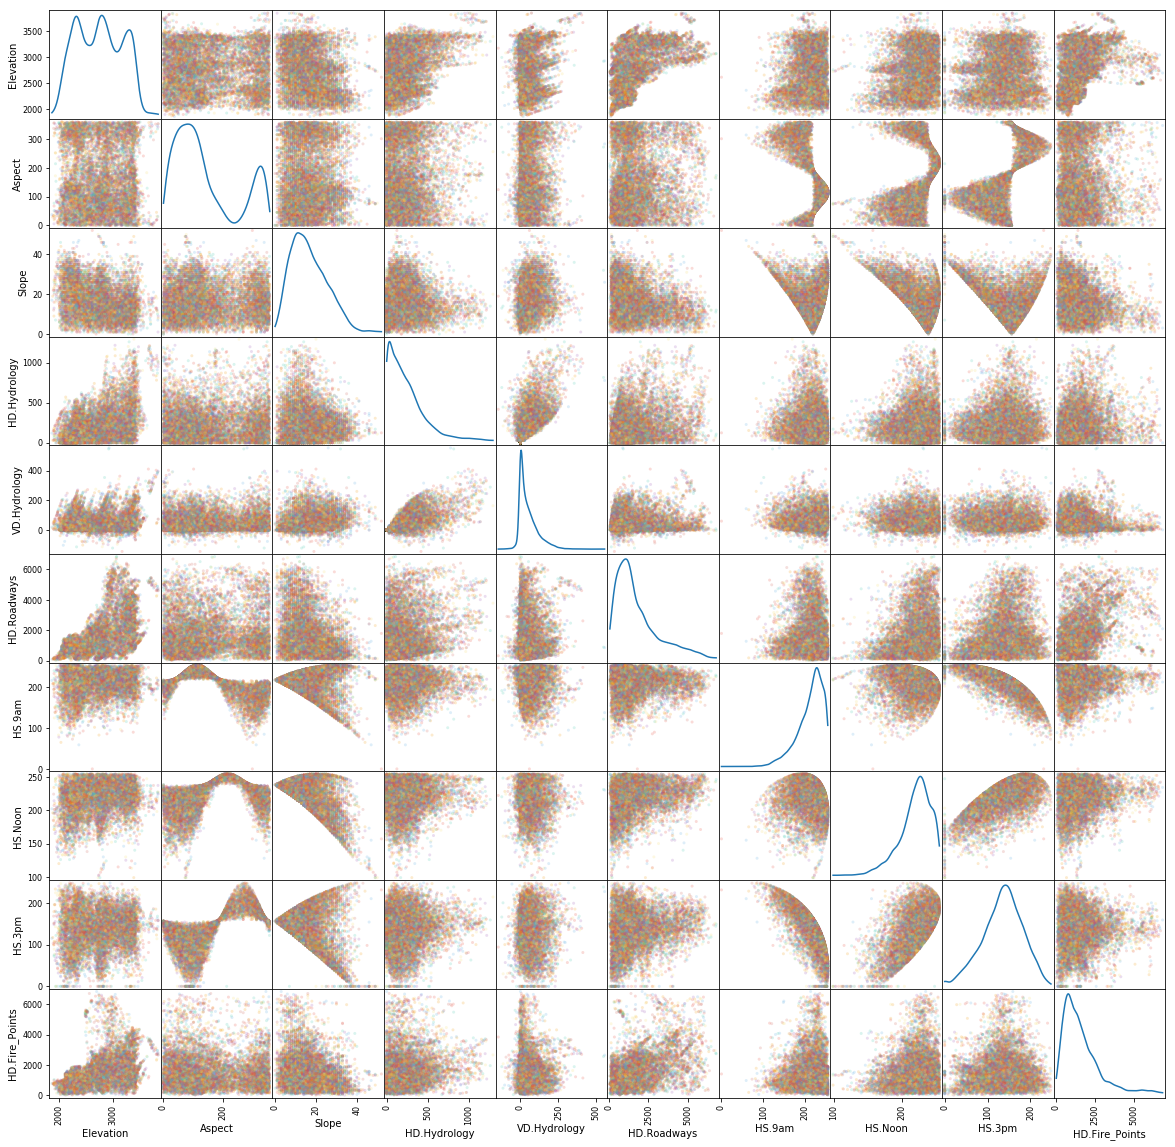

In [18]:
sctr_colors = ['#CD6155', '#9B59B6', '#5DADE2', '#48C9B0','#F7DC6F', '#F39C12', '#E74C3C']
scatter_matrix(train_data_10, alpha=0.2, figsize=(20, 20), diagonal='kde', c=sctr_colors)
plt.show()

Slope, VD.Hydrology, HD.Hydrology, HD.Roadways and HD.Fire_Points display distributions that are very skewed to the left while HS.9am and HS.Noon have right skewed distributions. It may be worthwhile to normalize these data points before using them in a model.

VD.Hydrology and HD.Hydrology appear to be positively correlated. HS.3pm shares a sigmoid relationship with Aspect.

We inspect the correlation matrix to inspect the corrrelation between these variables further.

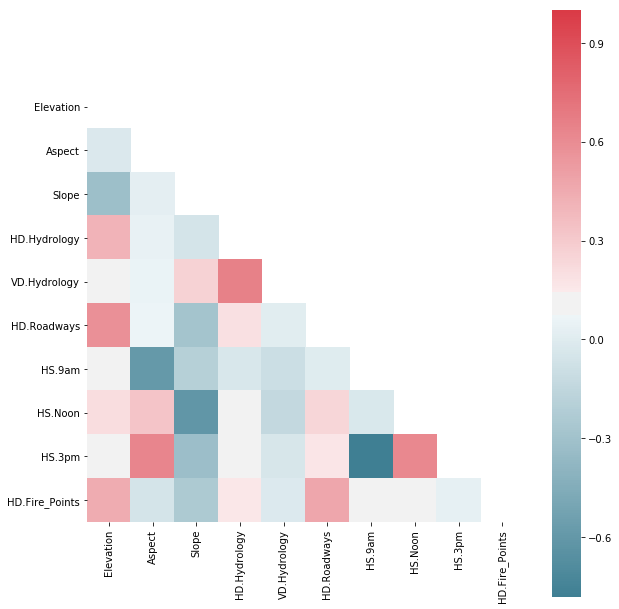

In [19]:
corr = train_data_10.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Use seaborn to create a pretty correlation heatmap.
fig, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax,  square=True)
fig.tight_layout()


We see that HD.Roadways & Elevation, HS.3pm & Aspect as well as HS.3pm and HS.noon are highly correlated. We should probably use only one of the features from the highly correlated pairs when testing the regression models.

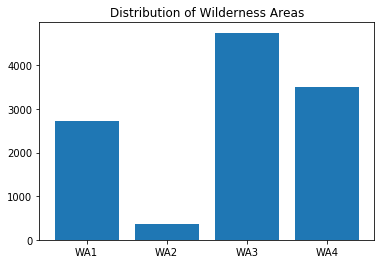

In [21]:
# Data Frame for Wilderness Area columns
df_wild_area=train_data.iloc[:,10:14]
# Data Frame with counts of each Wilderness Area
df_wild_area_plt = pd.DataFrame([(lbl, sum(df_wild_area[lbl])) for lbl in df_wild_area.columns]) \
                    .pivot_table(index=0, values=1)

#Plot counts of Wilderness Areas
plt.title("Distribution of Wilderness Areas")
plt.bar(df_wild_area_plt.index, df_wild_area_plt[1])
plt.show()

The training data consists of data for wilderness area 3 predominantly. There seem to be enough data points for wilderness areas 1 and 4 as well. Compared to the other 3, data points for wilderness area 2 are very less. Since the distribution of the data for wilderness types is not uniform, it may be a good idea to use cross validation when using these as features.

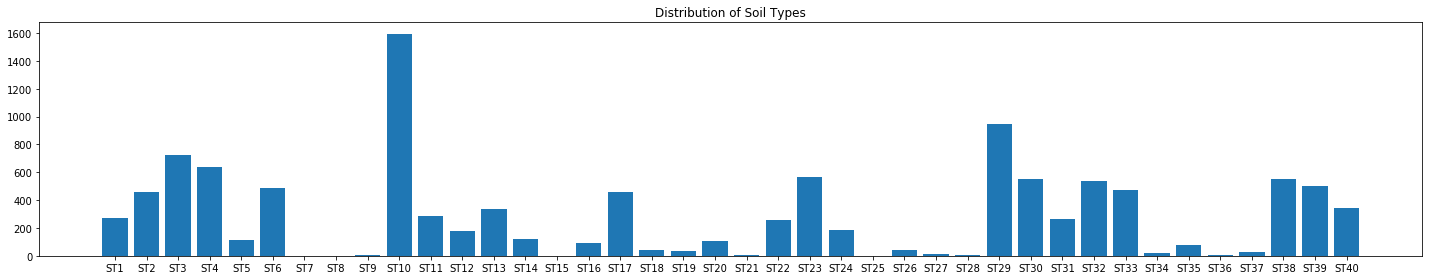

In [22]:
# Data Frame for Soil Type columns
df_soil_typ=train_data.iloc[:,14:]
# Data Frame with counts of each Soil Type
df_soil_typ_plt = pd.DataFrame([(lbl, sum(df_soil_typ[lbl])) for lbl in df_soil_typ.columns]) \
                    .pivot_table(index=0, values=1).reset_index()
df_soil_typ_plt.columns=['SoilType','Count']
df_soil_typ_plt.index=df_soil_typ_plt.SoilType.map(lambda x: int(x.replace('ST','')))
df_soil_typ_plt.sort_index(axis=0, level= 'int', inplace=True)

#Plot counts of Wilderness Areas
fig=plt.figure(figsize=(20,4))
plt.title("Distribution of Soil Types")
plt.bar(df_soil_typ_plt.SoilType, df_soil_typ_plt.Count)
plt.tight_layout()
plt.show()

The training data has the maximum number of data points corresponding to soil type 10. Soil Types 7, 8, 9, 15, 21, 25, 27, 28 and 36 have the least representation. Since the distribution of the data for soil types is not uniform, it may be a good idea to use cross validation when using these as features.

## Model Fitting and Predictions

### Utility Functions

In [19]:
# Function to binarize data
def binarize_data(data):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)
    # Set threshold based on mean and standard deviation
    thresholds = list(np.mean(data) + np.std(data))
    
    # Apply a threshold  to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data.values[:,feature] > thresholds[feature]
    return binarized_data

In [20]:
# Function to plot predicted cover type distribution
def plot_cover(pred_lbls, model): 
    pred_ctype = pd.DataFrame(pd.DataFrame(pred_lbls)[0].value_counts()).reset_index()
    pred_ctype.columns=['CoverType','Count']
    plt.bar(pred_ctype.CoverType, pred_ctype.Count)
    plt.title("Cover Type Prediction Using {}".format(model))
    plt.show()

In [21]:
#Get Grid CV parms
def get_best_parms(est, p_grid, scoring='accuracy'):
    gridcv = GridSearchCV(estimator=est, param_grid=p_grid)
    gridcv.fit(train_data, train_label)
    return gridcv.best_params_

In [22]:
# Function to print confusion matrix
def print_confusion(dev_lbl, pred_lbl):
    cmatrix=confusion_matrix(dev_lbl, pred_lbl)
    print("\nConfusion Matrix:\n{}".format(cmatrix))
    
    #Calculate precision and recall
    worst_precision = np.argmin([cmatrix[i,i]/sum(cmatrix[:,i]) for i in range(7)]) + 1
    print("\nCover Type with worst precision: {}".format(worst_precision))
    worst_recall = np.argmin([cmatrix[i,i]/sum(cmatrix[i]) for i in range(7)]) + 1
    print("Cover Type with worst recall: {}".format(worst_recall))

    #Most confused combination of cover types are assumed to be the ones that resulted in maximum
    #number of false positives or false negatives
    most_confused_index = np.where(cmatrix==max(cmatrix[i,j] for i in range(7) for j 
                                                in range(7) if i != j))
    print("Most confused cover types combination is ({},{})".format(most_confused_index[0][0] + 1, 
                                                           most_confused_index[1][0] + 1))

### Preprocessing

In [23]:
std_scalar=StandardScaler()
std_train_data=std_scalar.fit_transform(train_data)
std_dev_data=std_scalar.transform(dev_data)

In [24]:
# Binarize continuous data elements and combine with the binary columns
binarized_train_data = np.c_[binarize_data(train_data_10), train_data_rest]
binarized_dev_data = np.c_[binarize_data(dev_data_10), dev_data_rest]

### Feature Reduction

In [27]:
pca = PCA()
pca.fit(train_data)
pca_evr = pca.explained_variance_ratio_
for k in range(pca_evr.shape[0]):
        print("{:^35}|{:^35.4f}".format(k + 1, np.sum(pca_evr[:k + 1])))

                 1                 |              0.7237               
                 2                 |              0.9476               
                 3                 |              0.9834               
                 4                 |              0.9946               
                 5                 |              0.9987               
                 6                 |              0.9994               
                 7                 |              0.9998               
                 8                 |              1.0000               
                 9                 |              1.0000               
                10                 |              1.0000               
                11                 |              1.0000               
                12                 |              1.0000               
                13                 |              1.0000               
                14                 |              1.0000        

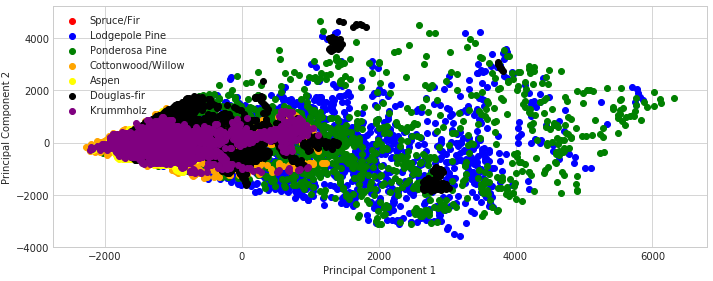

In [25]:
#PCA with 2 components for cluster representation
pca_model = PCA(n_components=2)
train_data_pca_two = pca_model.fit_transform(train_data)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 4))
    for index, lab, col in zip((0,1,2,3,4,5,6),('Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen'
             ,'Douglas-fir','Krummholz'),('red', 'blue', 'green', 'orange', 'yellow', 'black', 'purple')):
        plt.scatter(train_data_pca_two[train_label==index, 0], train_data_pca_two[train_label==index, 1],label=lab,c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper left')
    plt.tight_layout()

With 2 components we cannot clearly observe the different clusters to identify different cover types. Ponderosa Pine and Lodgepole Pine has similar distribution within graph. So it is possible that a classification algorithm make wrong predictions with only 2 components on PCA.

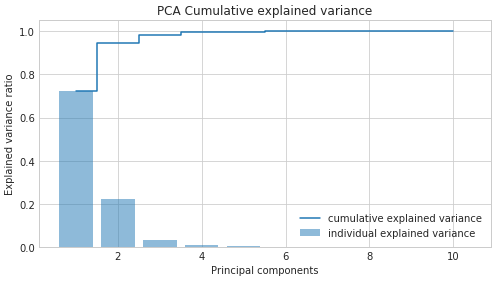

In [26]:
exp_variance = []
cum_exp_variance = []
pca = PCA(n_components=10)
pca.fit(train_data)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(7, 4))
    plt.title('PCA Cumulative explained variance')
    plt.bar(range(1,11), pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(1,11), np.cumsum(pca.explained_variance_ratio_), where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [28]:
pca_red = PCA(n_components=4)
train_data_red = pca_red.fit_transform(train_data)
dev_data_red = pca_red.transform(dev_data)

pca_red_evr = pca_red.explained_variance_ratio_
print(pca_red_evr)
pca_red_com = pca_red.components_
print(pca_red_com)

[0.72373408 0.22386633 0.03584732 0.0111423 ]
[[ 1.76463130e-01  1.94843142e-03 -1.67195758e-03  3.21221861e-02
   3.78094249e-04  8.12747279e-01  6.82501137e-04  3.37902399e-03
   4.26585153e-03  5.54286857e-01  1.25252974e-04 -3.33636141e-06
   3.71524593e-05 -1.59069072e-04 -1.43627060e-05 -1.47210480e-05
  -2.95033329e-05 -1.52016251e-05 -7.10566902e-06 -1.93028672e-05
   0.00000000e+00  0.00000000e+00 -3.44926083e-07 -5.87688501e-05
  -7.57934284e-06  1.03435857e-05 -1.39202405e-06 -6.50413375e-06
   0.00000000e+00 -4.66956073e-07 -1.24096943e-05  2.34538803e-06
   1.64947952e-06  4.34830448e-06 -1.50068489e-07  1.00410191e-05
   1.94209952e-05  4.02966731e-06  0.00000000e+00  1.49080083e-06
   5.56682090e-07 -1.33267972e-07  5.40928688e-05 -3.87636763e-06
   1.89787698e-06  4.99169975e-06  8.14749328e-06  4.06524397e-07
   2.96276328e-06  3.25866944e-07  2.11407094e-06  2.72214603e-05
   1.64623847e-05  1.89739481e-05]
 [-2.09193611e-02 -1.43060288e-02 -1.33311435e-04 -3.65402117

### Model Functions

In [29]:
# Function for testing Base models
def test_base(model, l_model):
    model.fit(train_data, train_label)
    preds=model.predict(dev_data)
    acc=model.score(dev_data, dev_label)
    print("Accuracy for Base Model: {:3.2%}".format(acc))
    
    #Append appropriate values to list and return
    l_model[0].append("Base")
    l_model[1].append(acc)
    l_model[2].append(preds)
    return l_model

In [30]:
# Function for testing Standardized models
def test_standardized(model, l_model):
    pipeline_m = Pipeline([("std_scalar",std_scalar), ("model",model)])
    pipeline_m.fit(train_data.values, train_label.values)
    preds = pipeline_m.predict(dev_data.values)
    acc = pipeline_m.score(dev_data.values, dev_label.values)
    print("Accuracy for Standardized Model: {:3.2%}".format(acc))
    
    #Append appropriate values to list and return
    l_model[0].append("Standardized")
    l_model[1].append(acc)
    l_model[2].append(preds)
    return l_model

In [31]:
# Function for testing models with binarized data
def test_binarized(model, l_model):
    model.fit(binarized_train_data, train_label)
    preds = model.predict(binarized_dev_data)
    acc = model.score(binarized_dev_data, dev_label)
    print("Accuracy for Binarized Data Model: {:3.2%}".format(acc))
    
    #Append appropriate values to list and return
    l_model[0].append("Binarized")
    l_model[1].append(acc)
    l_model[2].append(preds)
    return l_model

In [32]:
# Function for testing models with cross validation
def test_cv(model, l_model):
    #Contruct a KFolds object
    kf=KFold(40, shuffle=True)
    for train_index, test_index in kf.split(train_data.values):
        X_train, X_test=train_data.values[train_index], train_data.values[test_index]
        y_train = train_label.values[train_index]
        model.fit(X_train, y_train)
    preds = model.predict(dev_data.values)
    acc = model.score(dev_data.values, dev_label.values)
    print("Accuracy for Cross Validation Model: {:3.2%}".format(acc))
    
    #Append appropriate values to list and return
    l_model[0].append("Cross Validation")
    l_model[1].append(acc)
    l_model[2].append(preds)
    return l_model

In [33]:
# Function for testing models using only continuous data elements
def test_continuous(model, l_model):
    model.fit(train_data_10, train_label)
    preds = model.predict(dev_data_10)
    acc = model.score(dev_data_10, dev_label)
    print("Accuracy for Continuous Data Model: {:3.2%}".format(acc))
    
    #Append appropriate values to list and return
    l_model[0].append("Continuous")
    l_model[1].append(acc)
    l_model[2].append(preds)
    return l_model

In [34]:
# Function for testing models using only continuous data elements
def test_reduced(model, l_model):
    model.fit(train_data_red, train_label)
    preds = model.predict(dev_data_red)
    acc = model.score(dev_data_red, dev_label)
    print("Accuracy for Feature Reduced Data Model: {:3.2%}".format(acc))
    
    #Append appropriate values to list and return
    l_model[0].append("Feature Reduced")
    l_model[1].append(acc)
    l_model[2].append(preds)
    return l_model

In [35]:
#Function for testing different variations for various models
def test_model_variations(model, base_m=True, std_m=True, bin_m=True, cv_m=True, cont_m=True, red_m=True):
    #Initialize lists for storing model type, accuracy, predictions
    #as well as the actual model
    l_typ=[]
    l_acc=[]
    l_pred=[]
    #Wrapper list containing the above lists
    l_model=[l_typ, l_acc, l_pred]
    
    print("\nModel: {}\n".format(model))
    if base_m:
        l_model = test_base(model, l_model)
    if std_m:
        l_model = test_standardized(model, l_model)
    if bin_m:
        l_model = test_binarized(model, l_model)
    if cv_m:
        l_model = test_cv(model, l_model)
    if cont_m: 
        l_model = test_continuous(model, l_model)
    if red_m:
        l_model = test_reduced(model, l_model)
    return l_model

### Models

#### KNN

In [ ]:
# n_neighbors = [1,3,5,10,15,10]
# metric = ['manhattan','euclidean','minkowski'] 
# leaf_size = [5,10,20,30,50]
# p_grid = {'algorithm': algorithm, 'n_neighbors': n_neighbors, 'metric': metric, 'leaf_size': leaf_size}
# b_parm = get_best_parms(KNeighborsClassifier(), p_grid)
# b_parm


Model: KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Accuracy for Base Model: 85.82%
Accuracy for Standardized Model: 81.35%
Accuracy for Continuous Data Model: 85.74%
Accuracy for Feature Reduced Data Model: 80.82%

 Maximum accuracy using K Nearest Neighbors: 85.82%


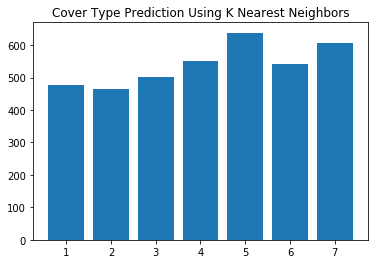

Predominant cover type predicted by K Nearest Neighbors model: Aspen

Confusion Matrix:
[[373  84   0   0  20   2  52]
 [ 92 361  18   0  46  16   7]
 [  0   6 430  20   9  60   0]
 [  0   0  11 518   0   7   0]
 [  1   7   2   0 560   1   0]
 [  1   3  41  14   3 456   0]
 [ 10   3   0   0   0   0 546]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (2,1)


In [36]:
model_name="K Nearest Neighbors"
knn_m = KNeighborsClassifier(n_neighbors=1, metric ='manhattan', leaf_size=10)
l_knn = test_model_variations(knn_m, True, True, False, False, True, True)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_knn[1])))
max_acc_ind=np.argmax(l_knn[1])  #Index for maximum accuray
best_preds=l_knn[2][max_acc_ind]  #Best prediction
#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

#Generate confusion matrix to understand which cover types are causing
#more confusion in classifications. It may be worthwhile to try and 're-engineer'
#the features based on the most confused cover types
print_confusion(dev_label, best_preds)

#### Gaussian Naive Bayes


Model: GaussianNB(priors=None)

Accuracy for Base Model: 59.15%
Accuracy for Cross Validation Model: 59.15%
Accuracy for Continuous Data Model: 60.40%

 Maximum accuracy using Gaussian NB: 60.40%


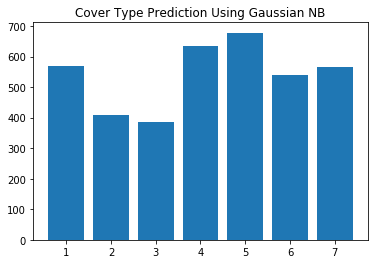

Predominant cover type predicted by Gaussian NB model: Aspen

Confusion Matrix:
[[330  68   6   0  39   6  82]
 [140 187  21   0 129  35  28]
 [  0   8 210 107  62 138   0]
 [  0   0  36 443   0  57   0]
 [  1 124   2   0 399  45   0]
 [  0  22 108  83  46 259   0]
 [ 98   1   2   0   3   0 455]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (2,1)


In [37]:
model_name="Gaussian NB"
gnb_m = GaussianNB()
l_gnb = test_model_variations(gnb_m, True, False, False, True, True, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_gnb[1])))
max_acc_ind=np.argmax(l_gnb[1])  #Index for maximum accuray
best_preds=l_gnb[2][max_acc_ind]  #Best prediction
#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### GMM

In [44]:
# best train accuracy
best_train_accuracy = 0.0
    
# best PCA components
best_pca_n = 2     
    
# best GMM components
best_gmm_n = 1
    
# best covariance type
best_cov = ' '
    
#loop over PCA components 
for i in range(4, 8):
    pca = PCA(n_components=i)
    trans_train_data = pca.fit_transform(train_data)
    
    # train_data with label 1 to 7

    data_1 = trans_train_data[train_label==1]
    data_2 = trans_train_data[train_label==2]
    data_3 = trans_train_data[train_label==3]
    data_4 = trans_train_data[train_label==4]
    data_5 = trans_train_data[train_label==5]
    data_6 = trans_train_data[train_label==6]
    data_7 = trans_train_data[train_label==7]
        
    # the covariance matrix type ('spherical', 'diag', 'tied', 'full')
    cov_type = ['spherical', 'diag', 'tied', 'full']
        
    #loop over cov_type        
    for cov in cov_type:
            
        # loop over GMM components 
        for nn in range (10, 11):
            
            gmm_1 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_1)
            gmm_2 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_2)
            gmm_3 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_3)
            gmm_4 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_4)
            gmm_5 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_5)
            gmm_6 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_6)
            gmm_7 = GMM(n_components=nn, covariance_type=cov, random_state=0).fit(data_7)
                        
            # probability of the test data
            prob_1 = gmm_1.score_samples(trans_train_data)
            prob_1 = np.exp(prob_1)

            prob_2 = gmm_2.score_samples(trans_train_data)
            prob_2 = np.exp(prob_2)

            prob_3 = gmm_3.score_samples(trans_train_data)
            prob_3 = np.exp(prob_3)

            prob_4 = gmm_4.score_samples(trans_train_data)
            prob_4 = np.exp(prob_4)  

            prob_5 = gmm_5.score_samples(trans_train_data)
            prob_5 = np.exp(prob_5)

            prob_6 = gmm_6.score_samples(trans_train_data)
            prob_6 = np.exp(prob_6)

            prob_7 = gmm_7.score_samples(trans_train_data)
            prob_7 = np.exp(prob_7)

            prob = np.vstack((prob_1, prob_2, prob_3, prob_4,prob_5,prob_6,prob_7)).T

            train_pred = np.argmax(prob, axis=1)+1
                
            # calculate accuracy by comparing prediction with test_lables
            accuracy = 1. * sum(train_pred == train_label) / len(train_label)

            if accuracy > best_train_accuracy:
                best_train_accuracy = accuracy
                best_pca_n = i
                best_gmm_n = nn
                best_cov = cov
     
                                                
print("best train accuracy: %.3f" %(best_train_accuracy))                 
print("best PCA component: ", best_pca_n)
print("best GMM component: ", best_gmm_n)
print("best covariance type: ", best_cov)

best train accuracy: 0.780
best PCA component:  7
best GMM component:  10
best covariance type:  full


#### Bernoulli Naive Bayes


Model: BernoulliNB(alpha=1e-05, binarize=0.0, class_prior=None, fit_prior=True)

Accuracy for Base Model: 59.44%
Accuracy for Standardized Model: 62.65%
Accuracy for Binarized Data Model: 61.88%
Accuracy for Cross Validation Model: 59.39%

 Maximum accuracy using Bernoulli NB: 62.65%


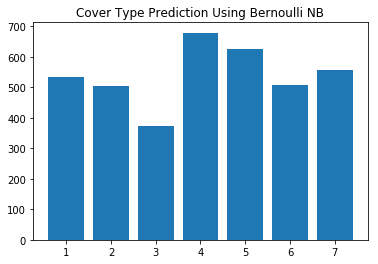

Predominant cover type predicted by Bernoulli NB model: Cottonwood/Willow

Confusion Matrix:
[[270 136   1   0  50   4  70]
 [141 247   5   2 107  20  18]
 [  1   3 222 120  29 150   0]
 [  0   0  29 485   0  22   0]
 [ 67  84  12   0 385  20   3]
 [  1   9 105  72  39 292   0]
 [ 53  24   0   0  15   0 467]]

Cover Type with worst precision: 2
Cover Type with worst recall: 3
Most confused cover types combination is (3,6)


In [38]:
model_name="Bernoulli NB"

bnb_m = BernoulliNB(alpha=0.00001)
l_bnb = test_model_variations(bnb_m, True, True, True, True, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_bnb[1])))
max_acc_ind=np.argmax(l_bnb[1])  #Index for maximum accuray
best_preds=l_bnb[2][max_acc_ind]  #Best prediction
#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Linear Regression


Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Accuracy for Base Model: 40.25%
Accuracy for Cross Validation Model: 40.22%

 Maximum accuracy using Linear Regression: 40.25%


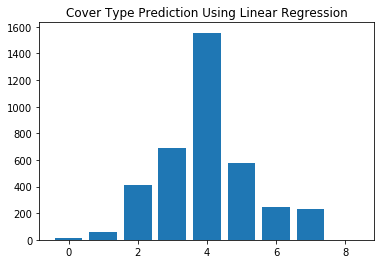

Predominant cover type predicted by Linear Regression model: Cottonwood/Willow

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0]
 [ 10  37 172 210  47  21  27   7   0]
 [  3  17 182 224  82  28   2   2   0]
 [  0   0   0  21 388 116   0   0   0]
 [  0   0   0  11 470  55   0   0   0]
 [  0   0  25 145 310  91   0   0   0]
 [  0   0   0  18 251 249   0   0   0]
 [  0   5  30  58   8  16 217 223   2]
 [  0   0   0   0   0   0   0   0   0]]

Cover Type with worst precision: 1
Cover Type with worst recall: 1
Most confused cover types combination is (4,5)


In [39]:
model_name="Linear Regression"
lr_m = LinearRegression()
l_lr = test_model_variations(lr_m, True, False, False, True, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_lr[1])))
max_acc_ind=np.argmax(l_lr[1])  #Index for maximum accuray
best_preds=np.rint(l_lr[2][max_acc_ind]).astype(int)  #Best prediction

# Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Logistic Regression


Model: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

Accuracy for Standardized Model: 67.70%
Accuracy for Binarized Data Model: 63.92%

 Maximum accuracy using Logistic Regression: 67.70%


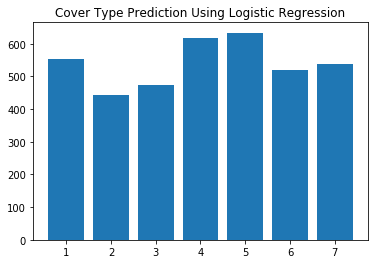

Predominant cover type predicted by Logistic Regression model: Aspen

Confusion Matrix:
[[344  89   1   0  37   5  55]
 [124 266   7   2 115  20   6]
 [  0   3 275  87  19 141   0]
 [  0   0  20 484   0  32   0]
 [ 12  65  51   0 417  26   0]
 [  0  19 117  46  41 295   0]
 [ 72   1   3   0   5   0 478]]

Cover Type with worst precision: 6
Cover Type with worst recall: 2
Most confused cover types combination is (3,6)


In [40]:
model_name="Logistic Regression"
logr_m = LogisticRegression(penalty='l2',C=0.1, tol=0.01, random_state=SEED)
l_logr = test_model_variations(logr_m, False, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_logr[1])))
max_acc_ind=np.argmax(l_logr[1])  #Index for maximum accuray
best_preds=l_logr[2][max_acc_ind]  #Best prediction
#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Neural Network

In [ ]:
# activation = ['identity', 'logistic', 'tanh', 'relu'] 
# alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
# p_grid = {'activation': activation, 'alpha': alphas}
# b_parm = get_best_parms(MLPClassifier(verbose=True, random_state=SEED), p_grid)
# b_parm


Model: MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.1,
       beta_2=0.3, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Accuracy for Base Model: 62.57%
Accuracy for Standardized Model: 82.70%
Accuracy for Binarized Data Model: 68.17%

 Maximum accuracy using Neural Network: 82.70%


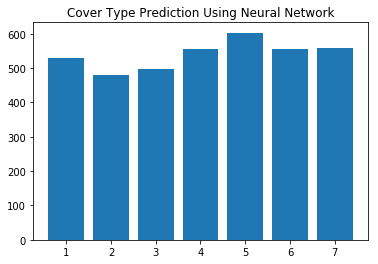

Predominant cover type predicted by Neural Network model: Aspen

Confusion Matrix:
[[381 100   1   3  16   1  29]
 [110 349  13   0  44  16   8]
 [  0   6 393  25  10  91   0]
 [  0   0   9 520   0   7   0]
 [  4  24   7   0 529   7   0]
 [  0   0  72   9   4 433   0]
 [ 35   1   2   0   0   0 521]]

Cover Type with worst precision: 1
Cover Type with worst recall: 2
Most confused cover types combination is (2,1)


In [41]:
model_name="Neural Network"

mlp_m = MLPClassifier(activation='tanh', alpha=0.00001, random_state=SEED, beta_1 = 0.1, beta_2=0.3)
l_mlp = test_model_variations(mlp_m, True, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_mlp[1])))
max_acc_ind=np.argmax(l_mlp[1])  #Index for maximum accuray
best_preds=l_mlp[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Decision Tree

In [ ]:
# criterion = ['gini', 'entropy']
# max_features = [None, 20, 40, 'auto','log2'] 
# max_depth = [None, 20, 30, 40]
# class_weight=[None,'balanced']
# p_grid = {'class_weight': class_weight, 'criterion': criterion, 'max_features': max_features, 'max_depth': max_depth}
# b_parm = get_best_parms(DecisionTreeClassifier(random_state=SEED), p_grid)
# b_parm


Model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Accuracy for Base Model: 80.08%
Accuracy for Standardized Model: 80.05%
Accuracy for Binarized Data Model: 68.07%

 Maximum accuracy using Decision Tree: 80.08%


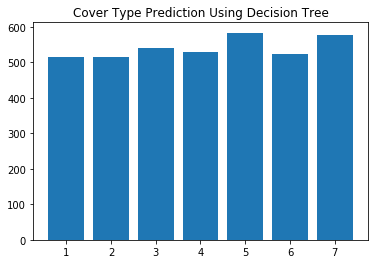

Predominant cover type predicted by Decision Tree model: Aspen

Confusion Matrix:
[[346 125   0   0  12   4  44]
 [129 321   9   0  53  19   9]
 [  0   6 421  16  14  68   0]
 [  0   0  25 502   0   9   0]
 [  8  49  12   0 497   5   0]
 [  0  13  74  10   4 417   0]
 [ 33   0   0   0   3   0 523]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (2,1)


In [42]:
model_name="Decision Tree"

dt_m = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features=None,max_depth=None, random_state=SEED)
l_dt = test_model_variations(dt_m, True, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_dt[1])))
max_acc_ind=np.argmax(l_dt[1])  #Index for maximum accuray
best_preds=l_dt[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Random Forest

In [ ]:
# criterion = ['gini', 'entropy']
# n_estimators = [50, 100, 150] 
# max_depth = [None, 20, 30, 40]
# min_samp_splt = [2,3,5]
# max_features = [None, 20, 40, 'log2','auto'] 
# p_grid = {'criterion': criterion, 'n_estimators': n_estimators, 'min_samples_split': min_samp_splt,
#           'max_features': max_features, 'max_depth': max_depth}
# b_parm = get_best_parms(RF(random_state=SEED), p_grid)
# b_parm


Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Accuracy for Base Model: 87.72%
Accuracy for Standardized Model: 87.70%
Accuracy for Binarized Data Model: 68.81%

 Maximum accuracy using Random Forest: 87.72%


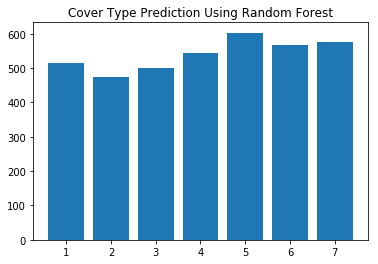

Predominant cover type predicted by Random Forest model: Aspen

Confusion Matrix:
[[411  78   1   0  11   2  28]
 [ 90 375  11   0  39  19   6]
 [  0   3 444  10   6  62   0]
 [  0   0   5 525   0   6   0]
 [  0  15   6   0 545   5   0]
 [  0   2  34   8   0 474   0]
 [ 15   0   0   0   2   0 542]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (2,1)


In [43]:
model_name="Random Forest"

rf_m = RF(criterion='entropy', n_estimators=150, min_samples_split=3, max_features=20,max_depth=None, random_state=SEED)
l_rf = test_model_variations(rf_m, True, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_rf[1])))
max_acc_ind=np.argmax(l_rf[1])  #Index for maximum accuray
best_preds=l_rf[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Gradient Boosting Classifier

In [ ]:
# n_estimators = [50, 100, 150] 
# max_depth = [3, 10, 25, 50]
# min_samp_splt = [2,3,5,7]
# p_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_splt': min_samp_splt}
# b_parm = get_best_parms(GDC(random_state=SEED), p_grid)
# b_parm


Model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=25,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

Accuracy for Base Model: 88.12%
Accuracy for Standardized Model: 88.17%
Accuracy for Binarized Data Model: 68.97%

 Maximum accuracy using Gradient Boosting Classifier: 88.17%


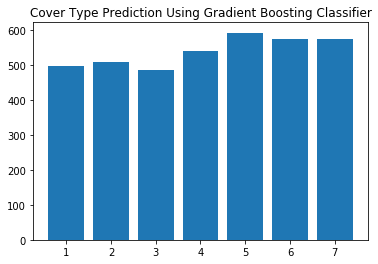

Predominant cover type predicted by Gradient Boosting Classifier model: Aspen

Confusion Matrix:
[[403  88   1   0   8   2  29]
 [ 80 396  10   0  35  14   5]
 [  0   5 440  11   4  65   0]
 [  0   0   8 524   0   4   0]
 [  2  16   5   0 543   5   0]
 [  0   2  23   7   0 486   0]
 [ 14   1   0   0   3   0 541]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (1,2)


In [44]:
model_name="Gradient Boosting Classifier"

gdc_m = GDC(n_estimators=100, max_depth=25, max_features=20, min_samples_split=7,random_state=SEED)
l_gdc = test_model_variations(gdc_m, True, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_gdc[1])))
max_acc_ind=np.argmax(l_gdc[1])  #Index for maximum accuray
best_preds=l_gdc[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Stochastic gradient descent (SGD)


Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Accuracy for Base Model: 33.60%
Accuracy for Standardized Model: 58.78%
Accuracy for Binarized Data Model: 60.77%
Accuracy for Continuous Data Model: 38.54%
Accuracy for Feature Reduced Data Model: 27.72%

 Maximum accuracy using Stochastic gradient descent: 60.77%


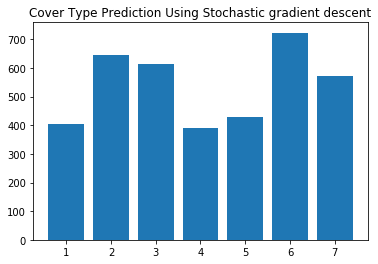

Predominant cover type predicted by Stochastic gradient descent model: Douglas-fir

Confusion Matrix:
[[230 169   2   0  37  13  80]
 [ 89 309  11   0  64  53  14]
 [  0   8 291  28   5 193   0]
 [  0   0 113 352   0  71   0]
 [ 23 134  62   0 299  53   0]
 [  0  15 132  10  23 338   0]
 [ 64  11   3   0   1   2 478]]

Cover Type with worst precision: 6
Cover Type with worst recall: 1
Most confused cover types combination is (3,6)


In [51]:
model_name="Stochastic gradient descent"
sgd_m = SGDClassifier(alpha=0.0001, loss='hinge',  penalty="l1", random_state=SEED)
l_sgd = test_model_variations(sgd_m, False, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_sgd[1])))
max_acc_ind=np.argmax(l_sgd[1])  #Index for maximum accuray
best_preds=l_sgd[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Extra Trees Classifier

In [ ]:
# n_estimators = [50, 100, 150] 
# criterion = ['gini', 'entropy']
# max_depth = [None, 20, 30, 40]
# max_features = [None, 20, 'log2','auto'] 
# p_grid = {'criterion': criterion, 'n_estimators': n_estimators, 'max_depth': max_depth,'max_features': max_features}
# b_parm = get_best_parms(ExtraTreesClassifier(random_state=SEED), p_grid)
# b_parm


Model: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features=54, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Accuracy for Base Model: 88.68%
Accuracy for Standardized Model: 88.68%
Accuracy for Binarized Data Model: 68.41%

 Maximum accuracy using Extra Trees Classifier: 88.68%


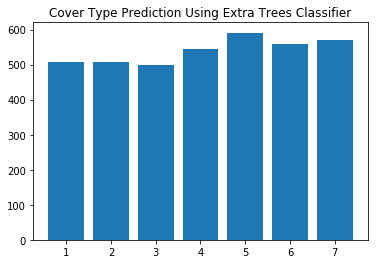

Predominant cover type predicted by Extra Trees Classifier model: Aspen

Confusion Matrix:
[[408  85   1   0   7   2  28]
 [ 80 401  11   0  28  16   4]
 [  0   5 449  13   7  51   0]
 [  0   0   7 526   0   3   0]
 [  1  13   4   0 547   6   0]
 [  0   2  28   6   0 482   0]
 [ 18   0   0   0   2   0 539]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (1,2)


In [45]:
model_name="Extra Trees Classifier"
etc_m = ExtraTreesClassifier(criterion='entropy', n_estimators=150, max_features=54,
          max_depth=30, random_state=SEED)
l_etc = test_model_variations(etc_m, True, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_etc[1])))
max_acc_ind=np.argmax(l_etc[1])  #Index for maximum accuray
best_preds=l_etc[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Support Vector Machines

In [ ]:
# gamma = [0.3, 'auto','scale']
# kernel = ['linear', 'poly', 'rbf'] 
# class_weight = ['balanced', None]
# p_grid = {'class_weight': class_weight, 'kernel': kernel, 'gamma': gamma}
# b_parm = get_best_parms(SVC(random_state=SEED), p_grid)


Model: SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True,
  tol=0.0001, verbose=False)

Accuracy for Standardized Model: 83.47%
Accuracy for Binarized Data Model: 68.52%

 Maximum accuracy using SVM: 83.47%


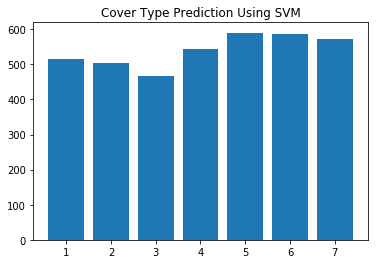

Predominant cover type predicted by SVM model: Aspen

Confusion Matrix:
[[379 108   1   0  11   2  30]
 [104 361  11   0  41  17   6]
 [  0   9 389  22   9  96   0]
 [  0   0  10 513   0  13   0]
 [  6  21   9   0 527   8   0]
 [  3   5  47  10   2 451   0]
 [ 24   0   0   0   0   0 535]]

Cover Type with worst precision: 2
Cover Type with worst recall: 2
Most confused cover types combination is (1,2)


In [68]:
model_name="SVM"
svc_m = SVC(C=10.0, class_weight='balanced', gamma=0.3, kernel='rbf', probability=True, random_state=SEED, tol=0.0001)  
l_svc = test_model_variations(svc_m, False, True, True, False, False, False)

print("\n Maximum accuracy using {}: {:3.2%}".format(model_name, np.amax(l_svc[1])))
max_acc_ind=np.argmax(l_svc[1])  #Index for maximum accuray
best_preds=l_svc[2][max_acc_ind]  #Best prediction

#Plot best predicted results
plot_cover(best_preds, model_name)

print("Predominant cover type predicted by {} model: {}"
      .format(model_name, cover_types[np.unique(best_preds)
                                      [np.argmax(np.unique(best_preds, return_counts=True)[1])] - 1]))

print_confusion(dev_label, best_preds)

#### Adaboost

In [247]:
#Best models for Extra Trees, Gradient Descent, Random
#Forest and Decision Tree Classifiers
best_etc_am=ExtraTreesClassifier(criterion='entropy', n_estimators=150, max_features=54,
          max_depth=30, random_state=SEED)
best_gdc_am = GDC(n_estimators=100, max_depth=25, max_features=20, min_samples_split=7,random_state=SEED)
best_rf_am = RF(criterion='entropy', n_estimators=150, min_samples_split=3, max_features=20,max_depth=None, random_state=SEED)
best_dt_am = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features=None,max_depth=None, random_state=SEED)

#Dict for the classifiers with better accuracy using base models
d_models={'ExtraTreesClassifier': best_etc_am, 'RandomForestClassifier': best_rf_am, 'DecisionTreeClassifier': best_dt_am}
#Dict for the classifiers with better accuracy using standardized models
d_std_models={'GradientBoostingClassifier': best_gdc_am}

#Run adaboost for classifiers using base models
for m_name, model in d_models.items():
    abc_m = AdaBoostClassifier(base_estimator=model, 
                               n_estimators=500,random_state=SEED)
    abc_m.fit(train_data, train_label)
    abc_m_pred = abc_m.predict(dev_data)
    print ('Accuracy for {}: {:3.2%}'
           .format(m_name, abc_m.score(dev_data,dev_label)))
    
#Run adaboost for classifiers using standardized models
for m_name, model in d_std_models.items():
    abc_m = AdaBoostClassifier(base_estimator=model, 
                               n_estimators=500,random_state=SEED)
    abc_m.fit(std_train_data, train_label)
    abc_m_pred = abc_m.predict(std_dev_data)
    print ('Accuracy for {}: {:3.2%}'
           .format(m_name, abc_m.score(std_dev_data,dev_label)))

Accuracy for ExtraTreesClassifier: 88.94%
Accuracy for RandomForestClassifier: 87.59%
Accuracy for DecisionTreeClassifier: 80.37%
Accuracy for GradientBoostingClassifier: 87.72%


We notice that Extra Trees and Decision Trees Classifiers with Adaboost actually perform better.

## Feature Engineering

We first test the model accuracies by removing different features that have all zeros for three or more cover types

In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pipeline_m = Pipeline([("std_scalar",MinMaxScaler(copy=True, feature_range=(0, 1))), \
                       ('reduce_dim',SelectKBest(chi2, k=50)),('classifier',ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features=50, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

pipeline_m.fit(train_data.values, train_label.values)

preds = pipeline_m.predict(dev_data.values)
acc = pipeline_m.score(dev_data.values, dev_label.values)

print("Accuracy for Model with Feature Reduction: {:3.2%}".format(acc))

Accuracy for Model with Feature Reduction: 88.78%


In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2

pipeline_m = Pipeline([("std_scalar",MinMaxScaler(copy=True, feature_range=(0, 1))), \
                       ('reduce_dim',SelectPercentile(chi2, percentile=50)),('classifier',ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features=20, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

pipeline_m.fit(train_data.values, train_label.values)

preds = pipeline_m.predict(dev_data.values)
acc = pipeline_m.score(dev_data.values, dev_label.values)

print("Accuracy for Model with Feature Reduction: {:3.2%}".format(acc))

Accuracy for Model with Feature Reduction: 84.79%


In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

pipeline_m = Pipeline([("std_scalar",MinMaxScaler(copy=True, feature_range=(0, 1))), \
                       ('reduce_dim',SelectFromModel(LinearSVC(penalty="l1", dual=False))),('classifier',ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features=30, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

pipeline_m.fit(train_data.values, train_label.values)

preds = pipeline_m.predict(dev_data.values)
acc = pipeline_m.score(dev_data.values, dev_label.values)

print("Accuracy for Model with Feature Reduction: {:3.2%}".format(acc))

Accuracy for Model with Feature Reduction: 89.10%


**Based on the intial models, we see the in most cases the confusion in prediction is either between 1 and 2 or 3 and 6. Next we engineer any features that can help in resolving the confusion**

In [279]:
#add new feature columns based on columns whose mean differences for cover type 1 and 2 are higher compared to other columns
train_data['fe1'] = train_data['HD.Roadways'] + train_data['HD.Fire_Points'] 
dev_data['fe1'] = dev_data['HD.Roadways']+ dev_data['HD.Fire_Points']
train_data['fe1c'] = train_data['HD.Roadways'] - train_data['HD.Fire_Points'] 
dev_data['fe1c'] = dev_data['HD.Roadways']- dev_data['HD.Fire_Points']
train_data['fe2'] = train_data['HD.Hydrology'] + train_data['Aspect'] 
dev_data['fe2'] = dev_data['HD.Hydrology']+ dev_data['Aspect']
train_data['fe3c'] = train_data['HD.Roadways'] - train_data['HD.Hydrology'] 
dev_data['fe3c'] = dev_data['HD.Roadways']- dev_data['HD.Hydrology']
train_data['fe4'] = train_data['HD.Fire_Points'] + train_data['Aspect'] 
dev_data['fe4'] = dev_data['HD.Fire_Points']+ dev_data['Aspect']
train_data['fe5'] = train_data['HD.Roadways'] + train_data['Aspect'] 
dev_data['fe5'] = dev_data['HD.Roadways']+ dev_data['Aspect']
train_data['fe5c'] = train_data['HD.Roadways'] - train_data['Aspect'] 
dev_data['fe5c'] = dev_data['HD.Roadways']- dev_data['Aspect']
train_data['fe6'] = train_data['HD.Fire_Points'] + train_data['HD.Hydrology'] 
dev_data['fe6'] = dev_data['HD.Fire_Points']+ dev_data['HD.Hydrology']
train_data['fe6c'] = train_data['HD.Fire_Points'] - train_data['HD.Hydrology'] 
dev_data['fe6c'] = dev_data['HD.Fire_Points']- dev_data['HD.Hydrology']
train_data['fe7'] = (train_data['HD.Fire_Points']* train_data['ST22']) + (train_data['HD.Hydrology'] *train_data['ST22'])
dev_data['fe7'] = (dev_data['HD.Fire_Points']*dev_data['ST22'])+ (dev_data['HD.Hydrology']*dev_data['ST22'])
train_data['fe13'] = train_data['Elevation'] - train_data['HD.Fire_Points'] 
dev_data['fe13'] = dev_data['Elevation']- dev_data['HD.Fire_Points']

In [59]:
# #Drop columns with all zeros
train_data.drop(['ST7','ST15'],axis=1, inplace=True)
dev_data.drop(['ST7','ST15'],axis=1, inplace=True)

In [281]:
#Linear SVC with Feature Reduction - Accuracy 89.10% , Std model
fr_lsvc_m = Pipeline([("std_scalar",MinMaxScaler(copy=True, feature_range=(0, 1))), \
                       ('reduce_dim',SelectFromModel(LinearSVC(penalty="l1", dual=False))),('classifier',ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features=30, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

fr_lsvc_m.fit(train_data.values, train_label.values)
fr_lsvc_preds = fr_lsvc_m.predict(dev_data.values)
fr_lsvc_acc=fr_lsvc_m.score(dev_data.values, dev_label)
print("Accuracy: {:3.2%}".format(fr_lsvc_acc))
fr_lsvc_pp=fr_lsvc_m.predict_proba(dev_data.values) # Predicted Probability
fr_lsvc_p=np.argmax(fr_lsvc_pp, axis=1)
fr_lsvc_p = fr_lsvc_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 90.58%


In [282]:
#ExtraTreesClassifier with Adaboost - Accuracy 88.94% , Base model
best_etc_am = ExtraTreesClassifier(criterion='entropy', n_estimators=150, max_features=54,
      max_depth=30, random_state=SEED)
abc_etc_am = AdaBoostClassifier(base_estimator=best_etc_am, 
                               n_estimators=500,random_state=SEED)
abc_etc_am.fit(train_data, train_label)
abc_etc_preds=abc_etc_am.predict(dev_data)
abc_etc_acc=abc_etc_am.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(abc_etc_acc))
abc_etc_pp=abc_etc_am.predict_proba(dev_data) # Predicted Probability
abc_etc_p=np.argmax(abc_etc_pp, axis=1)
abc_etc_p = abc_etc_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 90.13%


In [283]:
#ExtraTreesClassifier with Feature Reduction - Accuracy 88.78% , Std models
fr_etc_m = Pipeline([("std_scalar",MinMaxScaler(copy=True, feature_range=(0, 1))), \
                       ('reduce_dim',SelectKBest(chi2, k=50)),('classifier',ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features=50, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

fr_etc_m.fit(train_data.values, train_label.values)
fr_etc_preds = fr_etc_m.predict(dev_data.values)
fr_etc_acc=fr_etc_m.score(dev_data.values, dev_label)
print("Accuracy: {:3.2%}".format(fr_etc_acc))
fr_etc_pp=fr_etc_m.predict_proba(dev_data.values) # Predicted Probability
fr_etc_p=np.argmax(fr_etc_pp, axis=1)
fr_etc_p = fr_etc_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 90.00%


In [284]:
#ExtraTreesClassifier - Accuracy 88.68% , Base and Std models
best_etc_m = ExtraTreesClassifier(criterion='entropy', n_estimators=150, max_features=54,
      max_depth=30, random_state=SEED)
best_etc_m.fit(train_data, train_label)
best_etc_preds=best_etc_m.predict(dev_data)
best_etc_acc=best_etc_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_etc_acc))
etc_pp=best_etc_m.predict_proba(dev_data) # Predicted Probability
etc_p=np.argmax(etc_pp, axis=1)
etc_p = etc_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 90.45%


In [285]:
#GradientBoostingClassifier - Accuracy 88.17% , Std model
gdc_base_m = GDC(n_estimators=100, max_depth=25, max_features=20, min_samples_split=7,random_state=SEED)
best_gdc_m = Pipeline([("std_scalar",std_scalar), ("model",gdc_base_m)])
best_gdc_m.fit(train_data.values, train_label.values)
best_gdc_preds=best_gdc_m.predict(dev_data) 
best_gdc_acc=best_gdc_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_gdc_acc))
gdc_pp=best_gdc_m.predict_proba(dev_data)   # Predicted Probability
gdc_p=np.argmax(gdc_pp, axis=1)
gdc_p = gdc_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 89.81%


In [286]:
#RandomForestClassifier - Accuracy 87.72% , Base model
best_rf_m = RF(criterion='entropy', n_estimators=150, min_samples_split=3, max_features=20,max_depth=None, random_state=SEED)
best_rf_m.fit(train_data, train_label)
best_rf_preds=best_rf_m.predict(dev_data) 
best_rf_acc=best_rf_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_rf_acc))
rf_pp=best_rf_m.predict_proba(dev_data) # Predicted Probability
rf_p=np.argmax(rf_pp, axis=1)
rf_p = rf_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 88.94%


In [287]:
#KNeighborsClassifier - Accuracy 85.82% , Base model
best_knn_m = KNeighborsClassifier(n_neighbors=1, metric ='manhattan', leaf_size=10)
best_knn_m.fit(train_data, train_label)
best_knn_preds=best_knn_m.predict(dev_data) 
best_knn_acc=best_knn_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_knn_acc))
knn_pp=best_knn_m.predict_proba(dev_data) # Predicted Probability
knn_p=np.argmax(knn_pp, axis=1)
knn_p = knn_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 82.25%


In [288]:
#SVC - Accuracy 83.47% , Std model
svc_base_m = SVC(C=10.0, class_weight='balanced', gamma=0.3, kernel='rbf', probability=True, random_state=SEED, tol=0.0001)  
best_svc_m = Pipeline([("std_scalar",std_scalar), ("model",svc_base_m)])
best_svc_m.fit(train_data.values, train_label.values)
best_svc_preds=best_svc_m.predict(dev_data) 
best_svc_acc=best_svc_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_svc_acc))
svc_pp=best_svc_m.predict_proba(dev_data) # Predicted Probability
svc_p=np.argmax(svc_pp, axis=1)
svc_p = svc_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 85.53%


In [289]:
#MLPClassifier - Accuracy 82.7% , Std model
mlp_base_m = MLPClassifier(activation='tanh', alpha=0.00001, random_state=SEED, beta_1 = 0.1, beta_2=0.3)
best_mlp_m = Pipeline([("std_scalar",std_scalar), ("model",mlp_base_m)])
best_mlp_m.fit(train_data.values, train_label.values)
best_mlp_preds=best_mlp_m.predict(dev_data) 
best_mlp_acc=best_mlp_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_mlp_acc))
mlp_pp=best_mlp_m.predict_proba(dev_data) # Predicted Probability
mlp_p=np.argmax(mlp_pp, axis=1)
mlp_p = mlp_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 83.65%


In [290]:
#DecisionTreeClassifier with Adaboost - Accuracy 80.37% , Base model
best_dt_am = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features=None,max_depth=None, random_state=SEED)
abc_dt_am = AdaBoostClassifier(base_estimator=best_dt_am, 
                               n_estimators=500,random_state=SEED)
abc_dt_am.fit(train_data, train_label)
abc_dt_preds=abc_dt_am.predict(dev_data) 
abc_dt_acc=abc_dt_am.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(abc_dt_acc))
abc_dt_pp=abc_dt_am.predict_proba(dev_data) # Predicted Probability
abc_dt_p=np.argmax(abc_dt_pp, axis=1)
abc_dt_p = abc_dt_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 81.22%


In [291]:
#DecisionTreeClassifier - Accuracy 80.08% , Base model
best_dt_m = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features=None,max_depth=None, random_state=SEED)
best_dt_m.fit(train_data, train_label)
best_dt_preds=best_dt_m.predict(dev_data) 
best_dt_acc=best_dt_m.score(dev_data, dev_label)
print("Accuracy: {:3.2%}".format(best_dt_acc))
dt_pp=best_dt_m.predict_proba(dev_data) # Predicted Probability
dt_p=np.argmax(dt_pp, axis=1)
dt_p = dt_p + 1  # Predicted labels (based on predict_proba)

Accuracy: 80.63%


In [300]:
# Predict Labels based on the sum of the predicted probabilities of the top models
# weighted by the accuracy 

# Calculate sum of probabilities weighted proportional to the accuracy rank
# sum_wt_pp=np.sum((abc_etc_pp, etc_pp/2, gdc_pp/3, rf_pp/4, knn_pp/5, svc_pp/6, mlp_pp/7, abc_dt_pp/8), axis=0)
# sum_wt_pp=np.sum((fr_lsvc_pp* fr_lsvc_acc, abc_etc_pp* best_etc_acc, gdc_pp* best_gdc_acc, rf_pp*best_rf_acc, svc_pp*best_svc_acc, knn_pp*best_knn_acc), axis=0)
sum_wt_pp=np.sum((fr_lsvc_pp* fr_lsvc_acc, etc_pp* best_etc_acc, gdc_pp* best_gdc_acc), axis=0)
# Select index for maximum probability
sum_wt_p=np.argmax(sum_wt_pp, axis=1)
# Predict Label
sum_wt_p = sum_wt_p + 1
# Calculate Accuracy
sum_wt_acc = sum(sum_wt_p==dev_label)/len(dev_label)

print("Accuracy with sum of weighted predicted probabilities: {:3.2%}".format(sum_wt_acc))

Accuracy with sum of weighted predicted probabilities: 90.53%


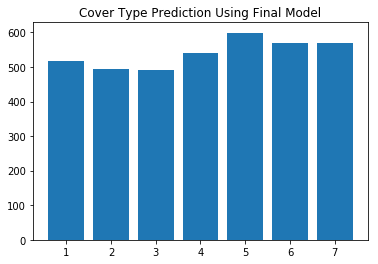

Predominant cover type predicted by Final Model model: Aspen


In [301]:
plot_cover(sum_wt_p, 'Final Model')

print("Predominant cover type predicted by {} model: {}"
      .format('Final Model', cover_types[np.unique(sum_wt_p)
                                      [np.argmax(np.unique(sum_wt_p, return_counts=True)[1])] - 1]))

## Test Data Predictions

In [397]:
test_data=test_data_orig.copy()
test_data.drop(['Id'],axis=1, inplace=True)

In [309]:
#add new feature columns based on columns whose mean differences for cover type 1 and 2 are higher compared to other columns
test_data['fe1'] = test_data['Horizontal_Distance_To_Roadways'] + test_data['Horizontal_Distance_To_Fire_Points'] 
test_data['fe1c'] = test_data['Horizontal_Distance_To_Roadways'] - test_data['Horizontal_Distance_To_Fire_Points'] 
test_data['fe2'] = test_data['Horizontal_Distance_To_Hydrology'] + test_data['Aspect'] 
test_data['fe3c'] = test_data['Horizontal_Distance_To_Roadways'] - test_data['Horizontal_Distance_To_Hydrology'] 
test_data['fe4'] = test_data['Horizontal_Distance_To_Fire_Points'] + test_data['Aspect'] 
test_data['fe5'] = test_data['Horizontal_Distance_To_Roadways'] + test_data['Aspect'] 
test_data['fe5c'] = test_data['Horizontal_Distance_To_Roadways'] - test_data['Aspect'] 
test_data['fe6'] = test_data['Horizontal_Distance_To_Fire_Points'] + test_data['Horizontal_Distance_To_Hydrology'] 
test_data['fe6c'] = test_data['Horizontal_Distance_To_Fire_Points'] - test_data['Horizontal_Distance_To_Hydrology'] 
test_data['fe7'] = (test_data['Horizontal_Distance_To_Fire_Points']* test_data['Soil_Type22']) + (test_data['Horizontal_Distance_To_Hydrology'] *test_data['Soil_Type22'])
test_data['fe13'] = test_data['Elevation'] - test_data['Horizontal_Distance_To_Fire_Points'] 
test_data.drop(['Soil_Type7','Soil_Type15'],axis=1, inplace=True)

In [311]:
#79.075
fr_lsvc_pp_tst=fr_lsvc_m.predict_proba(test_data.values) # Predicted Probability
fr_lsvc_p_tst=np.argmax(fr_lsvc_pp_tst, axis=1)
fr_lsvc_p_tst = fr_lsvc_p_tst + 1  # Predicted labels (based on predict_proba)

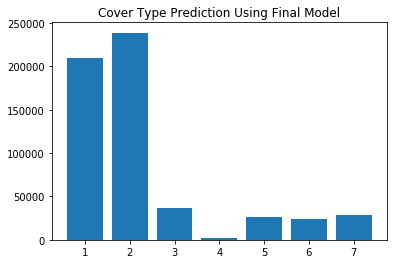

Predominant cover type predicted by Final Model model: Lodgepole Pine


In [312]:
plot_cover(fr_lsvc_p_tst, 'Final')

print("Predominant cover type predicted by {} model: {}"
      .format('Final Model', cover_types[np.unique(fr_lsvc_p_tst)
                                      [np.argmax(np.unique(fr_lsvc_p_tst, return_counts=True)[1])] - 1]))

In [313]:
test_data_sub = test_data_orig.copy()
test_data_sub['Cover_Type']=fr_lsvc_p_tst
test_data_sub_df = test_data_sub.loc[:, ['Id','Cover_Type']]
test_data_sub_df.to_csv('Submission.csv', index=None)

In [316]:
#78.613
fr_lsvc_pp_tst=fr_lsvc_m.predict_proba(test_data.values) 
etc_pp_tst=best_etc_m.predict_proba(test_data) 
gdc_pp_tst=best_gdc_m.predict_proba(test_data)   


sum_pp_tst=np.sum((fr_lsvc_pp_tst* fr_lsvc_acc, etc_pp_tst* best_etc_acc, gdc_pp_tst* best_gdc_acc), axis=0)
# Select index for maximum probability
sum_p_tst=np.argmax(sum_pp_tst, axis=1)
# Predict Label
sum_p_tst = sum_p_tst + 1

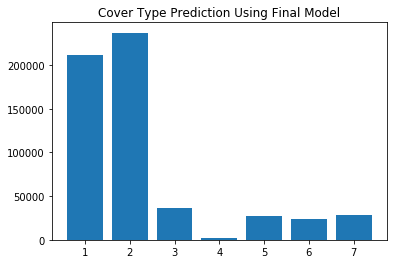

Predominant cover type predicted by Final Model model: Lodgepole Pine


In [317]:
plot_cover(sum_p_tst, 'Final')

print("Predominant cover type predicted by {} model: {}"
      .format('Final Model', cover_types[np.unique(sum_p_tst)
                                      [np.argmax(np.unique(sum_p_tst, return_counts=True)[1])] - 1]))

In [318]:
test_data_sub = test_data_orig.copy()
test_data_sub['Cover_Type']=sum_p_tst
test_data_sub_df = test_data_sub.loc[:, ['Id','Cover_Type']]
test_data_sub_df.to_csv('Submission.csv', index=None)